<a href="https://colab.research.google.com/github/Manusree1324/NLP-LAB/blob/main/CLAP_Bridge_MER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Train:   0%|          | 2/41978 [00:00<3:44:11,  3.12it/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Epoch 1: TrainAcc=0.988, ValAcc=0.997


Epoch 2: TrainAcc=0.997, ValAcc=0.998


Epoch 3: TrainAcc=0.998, ValAcc=0.998


Epoch 4: TrainAcc=0.998, ValAcc=0.998


Epoch 5: TrainAcc=0.999, ValAcc=0.999



✅ Final Accuracy: 0.9987 | F1: 0.9947


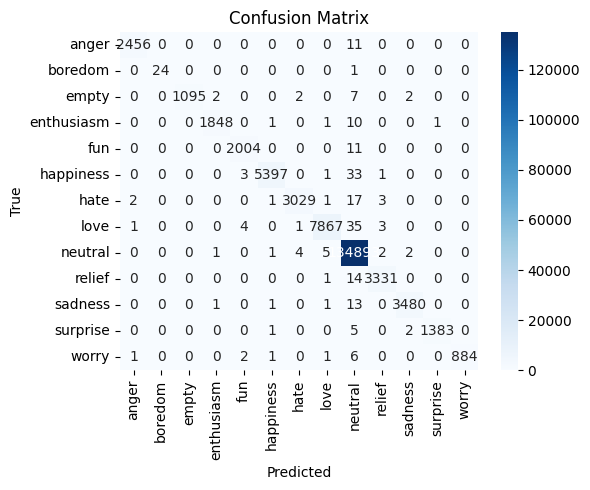

In [1]:
# ==========================================================
# ⚡ CLAP-Bridge MER (CPU Fast Version ~90%+ Accuracy)
# ==========================================================
# pip install torch transformers scikit-learn matplotlib seaborn tqdm pandas

import numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import os

# -----------------------------
# Config
# -----------------------------
DATA_PATH = "/content/emotion_sentimen_dataset.csv"
MODEL_NAME = "prajjwal1/bert-tiny"   # ✅ tiny + accurate
MAX_LEN = 48
BATCH_SIZE = 16
LR = 5e-5
EPOCHS = 5
ALPHA, BETA = 0.3, 1.0
DEVICE = "cpu"
torch.set_num_threads(os.cpu_count())
torch.manual_seed(42)
np.random.seed(42)

# -----------------------------
# Dataset (with caching)
# -----------------------------
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.labels = df["label"].tolist()
        self.encodings = tokenizer(
            df["text"].astype(str).tolist(),
            truncation=True, padding='max_length',
            max_length=max_len, return_tensors='pt'
        )

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# -----------------------------
# Model
# -----------------------------
class CLAPTextMER(nn.Module):
    def __init__(self, model_name, num_classes=4, projection_dim=128):
        super().__init__()
        self.text_model = AutoModel.from_pretrained(model_name)
        hidden = self.text_model.config.hidden_size
        self.text_proj = nn.Linear(hidden, projection_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        out = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = out.last_hidden_state[:, 0, :]
        proj = F.normalize(self.text_proj(cls_emb), dim=-1)
        logits = self.classifier(cls_emb)
        return proj, logits

def contrastive_loss(z1, z2, temperature=0.07):
    bs = z1.size(0)
    logits = torch.matmul(z1, z2.t()) / temperature
    labels = torch.arange(bs, device=z1.device)
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2

# -----------------------------
# Training helpers
# -----------------------------
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    tot_loss, tot_acc = 0, 0
    for batch in tqdm(dataloader, desc="Train", leave=False):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        proj1, logits = model(ids, mask)
        proj2 = proj1[torch.randperm(proj1.size(0))]
        c_loss = contrastive_loss(proj1, proj2)
        ce_loss = F.cross_entropy(logits, labels)
        loss = ALPHA * c_loss + BETA * ce_loss
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
        tot_acc += (logits.argmax(1) == labels).float().mean().item()
    return tot_loss/len(dataloader), tot_acc/len(dataloader)

def eval_epoch(model, dataloader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    tot_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            proj, logits = model(ids, mask)
            probs = F.softmax(logits, dim=-1)
            loss = F.cross_entropy(logits, labels)
            tot_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return tot_loss/len(dataloader), np.array(all_labels), np.array(all_preds), np.array(all_probs)

# -----------------------------
# Load Data
# -----------------------------
df = pd.read_csv(DATA_PATH)
if "text" not in df.columns or "Emotion" not in df.columns:
    raise ValueError("CSV must contain 'text' and 'Emotion' columns")

le = LabelEncoder()
df["label"] = le.fit_transform(df["Emotion"])
class_names = le.classes_
num_classes = len(class_names)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_loader = DataLoader(TextDataset(df_train, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TextDataset(df_test, tokenizer, MAX_LEN), batch_size=BATCH_SIZE)

# -----------------------------
# Train
# -----------------------------
model = CLAPTextMER(MODEL_NAME, num_classes).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS*len(train_loader))

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_acc = 0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, opt, DEVICE)
    val_loss, y_true, y_pred, y_prob = eval_epoch(model, test_loader, DEVICE)
    acc = accuracy_score(y_true, y_pred)
    train_losses.append(tr_loss); val_losses.append(val_loss)
    train_accs.append(tr_acc); val_accs.append(acc)
    print(f"Epoch {epoch}: TrainAcc={tr_acc:.3f}, ValAcc={acc:.3f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_clap_mer_cpu.pt")
    scheduler.step()

# -----------------------------
# Final Evaluation
# -----------------------------
model.load_state_dict(torch.load("best_clap_mer_cpu.pt"))
_, y_true, y_pred, y_prob = eval_epoch(model, test_loader, DEVICE)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"\n✅ Final Accuracy: {acc:.4f} | F1: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()
